# Postprocess inference

* **Last Modified**: 30-11-2023
* **Authors**: Gonzalo Mateo-García, Enrique Portalés-Julià
---

This notebook shows how to produce flood extent maps from Sentinel-2 and Landsat using the clouds aware flood sementation model proposed in:

> E. Portalés-Julià, G. Mateo-García, C. Purcell, and L. Gómez-Chova [Global flood extent segmentation in optical satellite images](https://www.nature.com/articles/s41598-023-47595-7). _Scientific Reports 13, 20316_ (2023). DOI: 10.1038/s41598-023-47595-7.

In particular, the notebook shows how to: query the available S2 and Landsat images, download them, run inference with the model and vectorize the model outputs to derive prepost event floodmaps. We focus in the region of Nova Kakhovka, Kherson, Ukraine, where recently a dam break caused several flooding. 

**Note**: If you run this notebook in Google Colab you may want to change the running environment to use a GPU.

## Step 1: Install and import the necessary packages

Install the `ml4floods` and `geemap` packages if not installed

```
!pip install geemap
!pip install ml4floods

```

In [1]:
import ee
# ee.Authenticate()
ee.Initialize()
from datetime import datetime, timezone
from georeader.readers import ee_query
from shapely.geometry import shape 
import geopandas as gpd
from georeader.readers import S2_SAFE_reader
from georeader.save import save_cog
from georeader import window_utils, mosaic
from georeader.plot import show
from georeader.rasterio_reader import RasterioReader
import os
import torch
import numpy as np
from georeader.geotensor import GeoTensor
from ml4floods.scripts.inference import load_inference_function, vectorize_outputv1
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.data import utils
import warnings
from rasterio.plot import show
from georeader.readers import ee_image
from ml4floods.models import postprocess
from georeader import plot
import matplotlib.pyplot as plt
from ml4floods.visualization import plot_utils

## Step 2: Define query parameters: area of interest and dates

The area of interest covers the region from Nova Kakhovka to Kherson. The following code defines this AoI and queries the available S2 and Landsat images and shows them using `geemap`.

In [2]:
aoi = shape({'type': 'Polygon',
 'coordinates': (((33.40965055141422, 46.849975215311474),
   (33.24671826582107, 46.923511440491325),
   (32.936224664974134, 46.845770100334164),
   (32.33368262768653, 46.62876156455022),
   (32.25990197005967, 46.514641087646424),
   (32.31216326921171, 46.408759851523826),
   (32.843998842939385, 46.56961795883814),
   (33.21905051921081, 46.72367854887557),
   (33.40965055141422, 46.849975215311474)),)})

aoi_gpd = gpd.GeoDataFrame({'geometry':aoi},index = [0]).set_crs('epsg:4326')

In [3]:
tz = timezone.utc
start_period = datetime.strptime('2023-05-31',"%Y-%m-%d").replace(tzinfo=tz)
end_period = datetime.strptime('2023-06-12',"%Y-%m-%d").replace(tzinfo=tz)

# This function returns a GEE collection of Sentinel-2 and Landsat 8 data and a Geopandas Dataframe with data related to the tiles, overlap percentage and cloud cover
flood_images_gee, flood_collection = ee_query.query(
    area=aoi, 
    date_start=start_period, 
    date_end=end_period,                                                   
    producttype="both", 
    return_collection=True, 
    add_s2cloudless=False)

flood_images_gee.groupby(["solarday","satellite"])[["cloudcoverpercentage","overlappercentage"]].agg(["count","mean"])

/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


cloudcoverpercentage            overlappercentage  \
                                    count       mean             count   
solarday   satellite                                                     
2023-05-31 S2B                          2  75.062169                 2   
2023-06-01 LC08                         2   2.070000                 2   
2023-06-02 LC09                         1  16.040000                 1   
2023-06-03 S2B                          2   4.788626                 2   
2023-06-05 S2A                          2   0.000000                 2   
2023-06-08 S2A                          2  95.540035                 2   
2023-06-09 LC09                         2   7.760000                 2   
2023-06-10 LC08                         1  93.430000                 1   
           S2B                          2  99.942521                 2   

                                 
                           mean  
solarday   satellite             
2023-05-31 S2B        27.434830  
2023-06-01 LC08       78.634958  
2023-06-02 LC09       75.542523  
2023-06-03 S2B        56.100742  
2023-06-05 S2A        27.990063  
2023-06-08 S2A        56.100742  
2023-06-09 LC09       79.054185  
2023-06-10 LC08       67.152296  
           S2B        27.707824

In [4]:
import geemap.foliumap as geemap
import folium

tl = folium.TileLayer(
            tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
            attr='Google',
            name="Google Satellite",
            overlay=True,
            control=True,
            max_zoom=22,
        )

m = geemap.Map(location=aoi.centroid.coords[0][-1::-1], 
               zoom_start=8)

tl.add_to(m)

flood_images_gee["localdatetime_str"] = flood_images_gee["localdatetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
showcolumns = ["geometry","overlappercentage","cloudcoverpercentage", "localdatetime_str","solarday","satellite"]
colors = ["#ff7777", "#fffa69", "#8fff84", "#52adf1", "#ff6ac2","#1b6d52", "#fce5cd","#705334"]
   
# Add the extent of the products
for i, ((day,satellite), images_day) in enumerate(flood_images_gee.groupby(["solarday","satellite"])):
    images_day[showcolumns].explore(
        m=m, 
        name=f"{satellite}: {day} outline", 
        color=colors[i % len(colors)], 
        show=False)

# Add the satellite data
for (day, satellite), images_day in flood_images_gee.groupby(["solarday", "satellite"]):    
    image_col_day_sat = flood_collection.filter(ee.Filter.inList("title", images_day.index.tolist()))    
    bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
    m.addLayer(image_col_day_sat, 
               {"min":0, "max":3000 if satellite.startswith("S2") else 0.3, "bands": bands},
               f"{satellite}: {day}",
               False)

aoi_gpd.explore(style_kwds={"fillOpacity": 0}, color="black", name="AoI", m=m)
folium.LayerControl(collapsed=False).add_to(m)
m

By looking at the map with the images available we select the pre and post event images from Sentinel-2

In [5]:
date_pre = "2023-06-03"
pre_flood = flood_images_gee[flood_images_gee.solarday == date_pre]

date_post = "2023-06-08"
post_flood = flood_images_gee[flood_images_gee.solarday == date_post]
post_flood

,geometry,cloudcoverpercentage,gee_id,proj,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite,localdatetime_str
title,,,,,,,,,,,,,
S2A_MSIL1C_20230608T084601_N0509_R107_T36TVS_20230608T104959,"POLYGON ((31.70898 45.95835, 31.70900 45.95835...",91.090149,20230608T084601_20230608T084938_T36TVS,"{'type': 'Projection', 'crs': 'EPSG:32636', 't...",1686214645530,COPERNICUS/S2_HARMONIZED,2023-06-08 08:57:25.530000+00:00,83.282631,2023-06-08 11:07:04.427835+00:00,2023-06-08,2023-06-08 08:57:25.530000+00:00,S2A,2023-06-08 08:57:25
S2A_MSIL1C_20230608T084601_N0509_R107_T36TWS_20230608T104959,"POLYGON ((34.44238 46.94462, 34.44228 46.94471...",99.989920,20230608T084601_20230608T084938_T36TWS,"{'type': 'Projection', 'crs': 'EPSG:32636', 't...",1686214640951,COPERNICUS/S2_HARMONIZED,2023-06-08 08:57:20.951000+00:00,28.918853,2023-06-08 11:11:50.363462+00:00,2023-06-08,2023-06-08 08:57:20.951000+00:00,S2A,2023-06-08 08:57:20


## Step 3: Read the data 

There are Sentinel-2 cloud free images on 2023-06-03 and 2023-06-05 but only the first one covers the entire AoI. For the postflood data we will use 2023-06-08, which is partially cloudy but allows to see some flood extent. We will read and mosaic the tiles T36TVS and T36TWS using **georeader**. 
The advantage of this workflow over Google Earth Engine (GEE) is that the images are read directly from the Sentinel-2 public bucket into the jupyter notebook. Also, there is no size limit in the download, which may cause GEE tasks to fail sometimes. 

In [6]:
%%time

dir_cache = "cache_s2"
os.makedirs(dir_cache, exist_ok=True)

def mosaic_s2(products, polygon, channels):
    products_read = products.index
    s2objs = []
    for product in products_read:
        s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product+".SAFE", check_exists=False)
        s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=channels)
        s2obj = s2obj.cache_product_to_local_dir(dir_cache)
        s2objs.append(s2obj)
    
    polygon_read_dst_crs = window_utils.polygon_to_crs(polygon, 
                                                       crs_polygon="EPSG:4326", dst_crs=s2objs[0].crs)
    
    data_memory = mosaic.spatial_mosaic(s2objs, polygon=polygon_read_dst_crs, dst_crs= s2objs[0].crs)
    
    return data_memory

channels = S2_SAFE_reader.BANDS_S2_L1C
tiff_pre = f"{date_pre}.tif"
if not os.path.exists(tiff_pre):
    print(f"Downloading files {tiff_pre}")
    pre_flood_memory = mosaic_s2(pre_flood, aoi,channels)
    save_cog(pre_flood_memory, tiff_pre, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    print(f"Reading file {tiff_pre}")
    pre_flood = RasterioReader(tiff_pre)
    channels = pre_flood.descriptions
    pre_flood = pre_flood.load()
    pre_flood_memory = pre_flood.values

tiff_post = f"{date_post}.tif"
if not os.path.exists(tiff_post):
    print(f"Downloading file {tiff_post}")
    post_flood_memory = mosaic_s2(post_flood, aoi,channels)
    save_cog(post_flood_memory, tiff_post, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    print(f"Reading file {tiff_post}")
    post_flood = RasterioReader(tiff_post)
    channels = post_flood.descriptions
    post_flood = post_flood.load()
    post_flood_memory = post_flood.values


Reading file 2023-06-03.tif
Reading file 2023-06-08.tif
CPU times: user 5min 10s, sys: 12.2 s, total: 5min 22s
Wall time: 5min 24s


## Step 3: Load the model

For this we will use an Ml4floods multioutput binary model trained on the WorldFloods data set. See the [paper](https://www.nature.com/articles/s41598-023-47595-7).

In [7]:
from huggingface_hub import hf_hub_download
# os.makedirs("models/WF2_unetv2_bgriswirs", exist_ok=True)
experiment_name = "WF2_unetv2_bgriswirs"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="config.json",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="model.pt",
                              local_dir=".", local_dir_use_symlinks=False)

models/WF2_unetv2_bgriswirs/config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

In [8]:
%%time

inference_function, config = load_inference_function(subfolder_local, device_name = 'cpu', max_tile_size=1024,
                                                     th_water=0.6, th_brightness=3500, distinguish_flood_traces=True)

channel_configuration = config['data_params']['channel_configuration']
channels  = get_channel_configuration_bands(channel_configuration, collection_name='S2')

Loaded model weights: models/WF2_unetv2_bgriswirs/model.pt
Getting model inference function
CPU times: user 71.6 ms, sys: 18.8 ms, total: 90.4 ms
Wall time: 73.2 ms


In [9]:
def predict(input_tensor, channels = [1, 2, 3, 7, 11, 12] ):
    input_tensor = input_tensor.astype(np.float32)
    input_tensor = input_tensor[channels]
    torch_inputs = torch.tensor(np.nan_to_num(input_tensor))
    return inference_function(torch_inputs)

## Step 4: Run inference

In [10]:
%%time

postflood_pred = f"{date_post}_pred.tif"
if not os.path.exists(postflood_pred):
    prediction_postflood, prediction_postflood_cont  = predict(post_flood_memory)
    prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=post_flood.transform,
                                            fill_value_default=0, crs=post_flood.crs)
    save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"], 
             tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
else:
    prediction_postflood_raster = RasterioReader(postflood_pred).load().squeeze()

preflood_pred = f"{date_pre}_pred.tif"
if not os.path.exists(preflood_pred):
    prediction_preflood, prediction_preflood_cont = predict(pre_flood_memory)
    # Remove flood traces from pre-flood
    prediction_preflood[prediction_preflood==4] = 1
    
    prediction_preflood_raster = GeoTensor(prediction_preflood.numpy(), transform=pre_flood.transform,
                                           fill_value_default=0, crs=pre_flood.crs)
    
    save_cog(prediction_preflood_raster, preflood_pred, descriptions=["pred"], 
             tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
else:
    prediction_preflood_raster = RasterioReader(preflood_pred).load().squeeze()

CPU times: user 300 ms, sys: 64 ms, total: 364 ms
Wall time: 365 ms


In [11]:
COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       [60, 85, 92]], # 5: flood_trace
                    dtype=np.float32) / 255

## Step 5: Plot the results

Text(0.5, 1.0, '2023-06-08 floodmap')

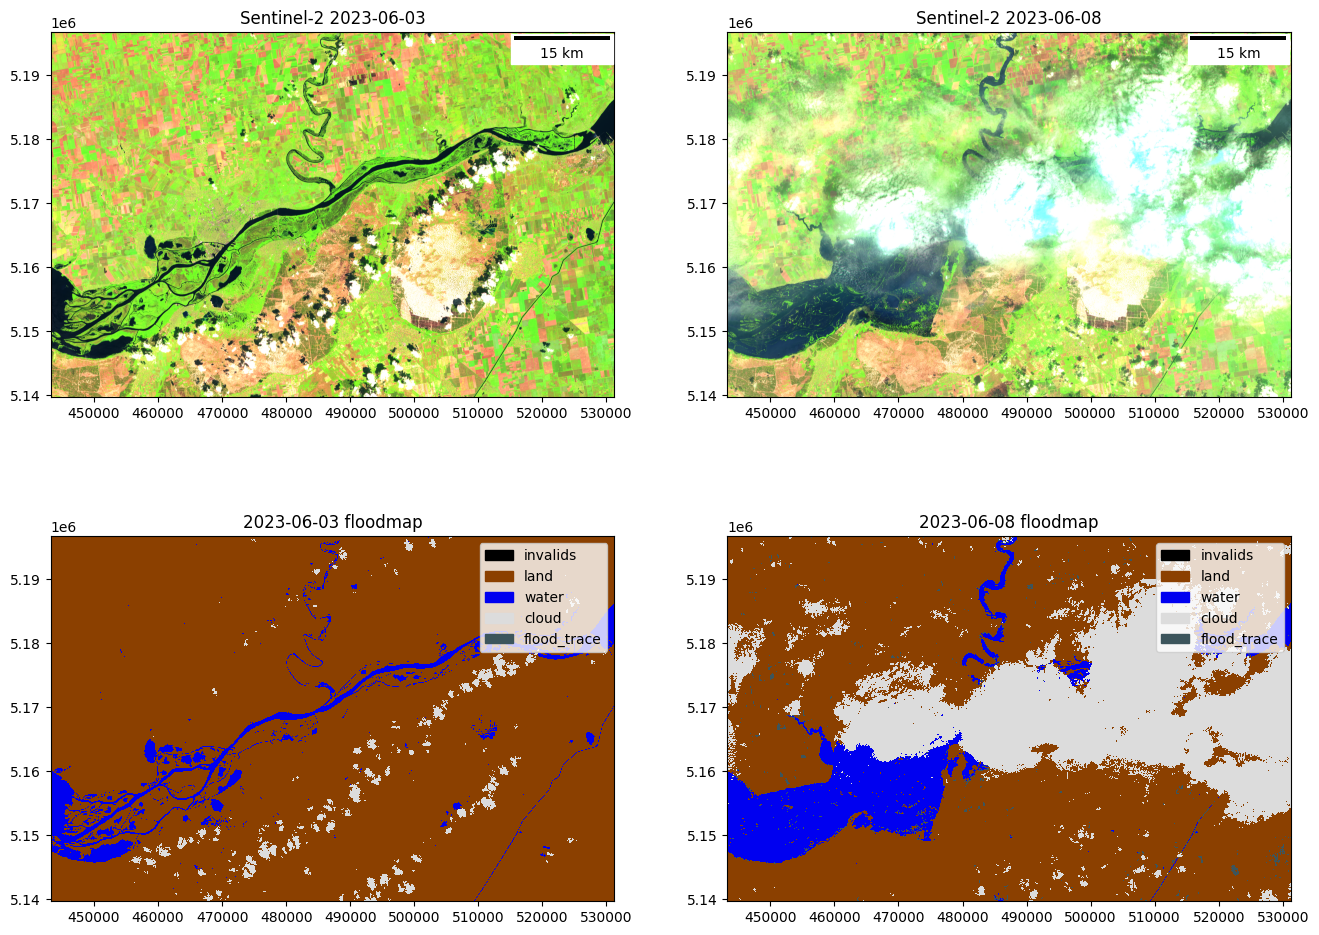

In [12]:
fig, ax = plt.subplots(2,2,figsize=(16,12),squeeze=False)


plot_utils.plot_swirnirred_image(pre_flood_memory,ax = ax[0,0],transform = pre_flood.transform, add_scalebar = True )
ax[0,0].set_title(f"Sentinel-2 {date_pre}")

plot_utils.plot_swirnirred_image(post_flood_memory,ax = ax[0,1],transform = post_flood.transform, add_scalebar = True )
ax[0,1].set_title(f"Sentinel-2 {date_post}")


plot.plot_segmentation_mask(prediction_preflood_raster, COLORS_PRED, ax=ax[1,0],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"])


ax[1,0].set_title(f"{date_pre} floodmap")

plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1,1],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"])

ax[1,1].set_title(f"{date_post} floodmap")

## Step 5: Vectorize predictions into prepost flood products



In [13]:
prediction_preflood_raster.shape

(5700, 8800)

In [14]:
preflood_shape = vectorize_outputv1(prediction_preflood_raster.values, 
                                    prediction_preflood_raster.crs, 
                                    prediction_preflood_raster.transform)
postflood_shape = vectorize_outputv1(prediction_postflood_raster.values, 
                                     prediction_postflood_raster.crs, 
                                     prediction_postflood_raster.transform)
postflood_shape.shape

(2893, 3)

Text(0.5, 1.0, '2023-06-08 floodmap')

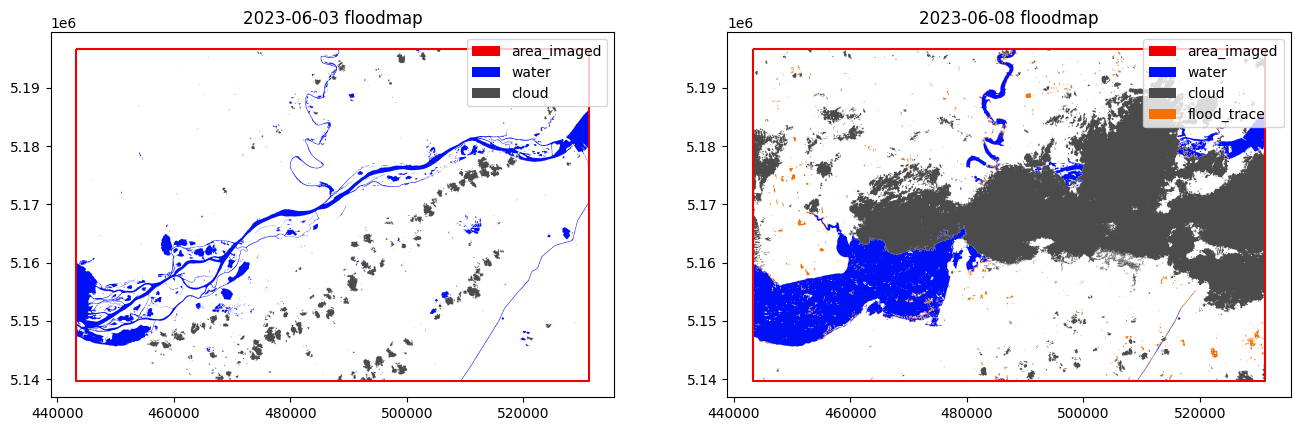

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
plot_utils.plot_floodmap(preflood_shape, ax=ax[0])
ax[0].set_title(f"{date_pre} floodmap")
plot_utils.plot_floodmap(postflood_shape, ax=ax[1])
ax[1].set_title(f"{date_post} floodmap")

/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/gonzalo/mambaforge/envs/ml4floods2/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result =

<Axes: >

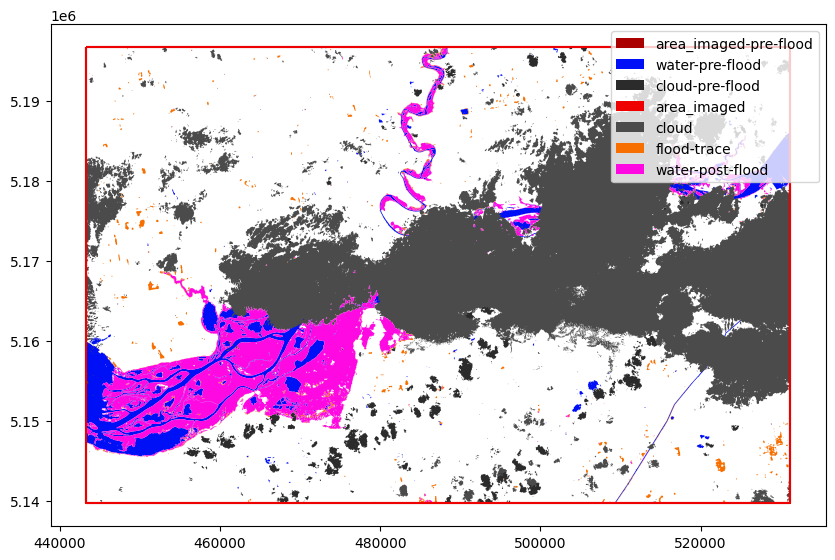

In [16]:
prepost_shape = postprocess.compute_pre_post_flood_water(postflood_shape, preflood_shape)
plot_utils.plot_floodmap(prepost_shape)

### Run inference in Landsat 8/9

There is a cloud free Landsat 9 image from the 2023-06-09. In the following cells we downloaded the image from Google Earth Engine, we run inference on it and show how to aggregate several post-flood maps over time of images acquired by different sensors.

In [17]:
%%time

bands_l89 = ["B2", "B3", "B4", "B5", "B6", "B7"]
postfloodsl9 = []
for l89_image_info in flood_images_gee[flood_images_gee.solarday == "2023-06-09"].itertuples():
    asset_id = f"{l89_image_info.collection_name}/{l89_image_info.gee_id}"
    geom = l89_image_info.geometry.intersection(aoi)
    postfloodsl9.append(ee_image.export_image_getpixels(asset_id, geom, proj=l89_image_info.proj, 
                                                        bands_gee=bands_l89))

dst_crs = postfloodsl9[0].crs
aoi_dst_crs = window_utils.polygon_to_crs(aoi, crs_polygon="EPSG:4326", dst_crs=dst_crs)
postfloodl9 = mosaic.spatial_mosaic(postfloodsl9, polygon=aoi_dst_crs, dst_crs=dst_crs)
postfloodl9.values[postfloodl9.values == postfloodl9.fill_value_default] = 0
postfloodl9.fill_value_default = 0

post_flood_l9_data = postfloodl9.values * 10000
postfloodl9

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

CPU times: user 2.35 s, sys: 537 ms, total: 2.89 s
Wall time: 1min 18s


 
         Transform: | 30.00, 0.00, 443205.00|
| 0.00,-30.00, 5196705.00|
| 0.00, 0.00, 1.00|
         Shape: (6, 1900, 2933)
         Resolution: (30.0, 30.0)
         Bounds: (443205.0, 5139705.0, 531195.0, 5196705.0)
         CRS: EPSG:32636
         fill_value_default: 0
        

In [18]:
save_cog(postfloodl9, "2023-06-09.tif", descriptions=bands_l89)

In [19]:
postflood_pred = f"2023-06-09_pred.tif"

prediction_postflood, prediction_postflood_cont  = predict(post_flood_l9_data, channels = [0, 1, 2, 3, 4, 5])
prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=postfloodl9.transform,
                                        fill_value_default=0, crs=postfloodl9.crs)

save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"], 
         tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})


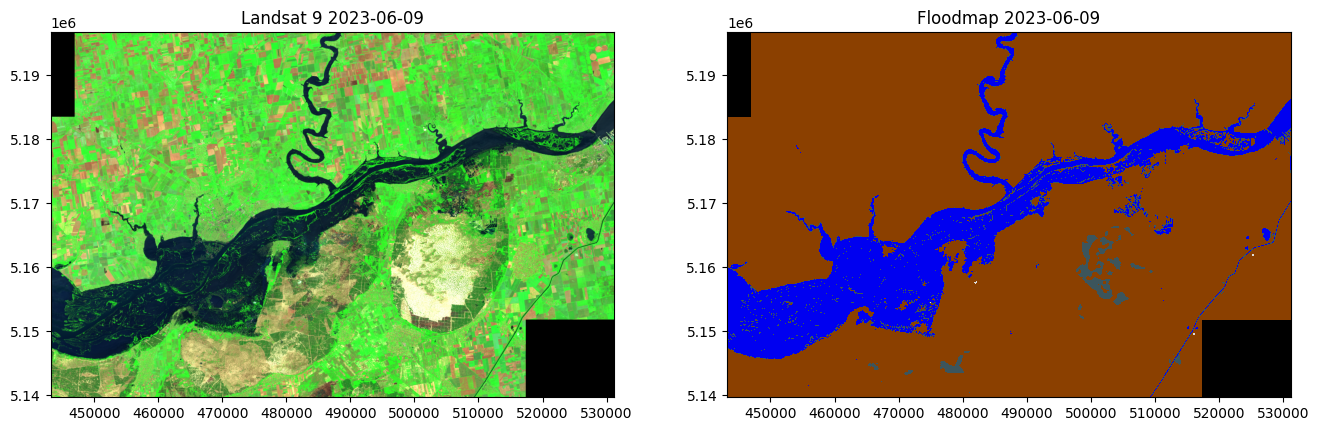

In [20]:
fig, ax = plt.subplots(1,2,figsize=(16,12))

show(np.clip(post_flood_l9_data[[5, 3, 2],:,:] / 3500, 0, 1),
     ax = ax[0],transform = postfloodl9.transform)


ax[0].set_title(f"Landsat 9 2023-06-09")


plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"], legend = False)
ax[1].set_title(f"Floodmap 2023-06-09")

plt.show()    

In [21]:
post_flood_shape_l9 = vectorize_outputv1(prediction_postflood_raster.values, 
                                    prediction_postflood_raster.crs, 
                                    prediction_postflood_raster.transform)

## Join the floodmaps of Sentinel-2 and Landsat

Here we join the floodmaps of the two satellites using the `max` mode.

In [22]:
warnings.filterwarnings('ignore')

area_imaged = post_flood_shape_l9.loc[post_flood_shape_l9['class'] =='area_imaged']

# Remove flood traces for the max extent join
post_flood_shape_l9 = post_flood_shape_l9.loc[post_flood_shape_l9['class'] !='flood_trace']
post_flood_shape = postflood_shape.loc[postflood_shape['class'] !='flood_trace']

postflood_mosaic = postprocess.mosaic_floodmaps([post_flood_shape, post_flood_shape_l9], area_imaged.geometry.values[0], mode = 'max', 
                                                classes_water=['water','flood_trace'])

Text(0.5, 1.0, 'Mosaic floodmap')

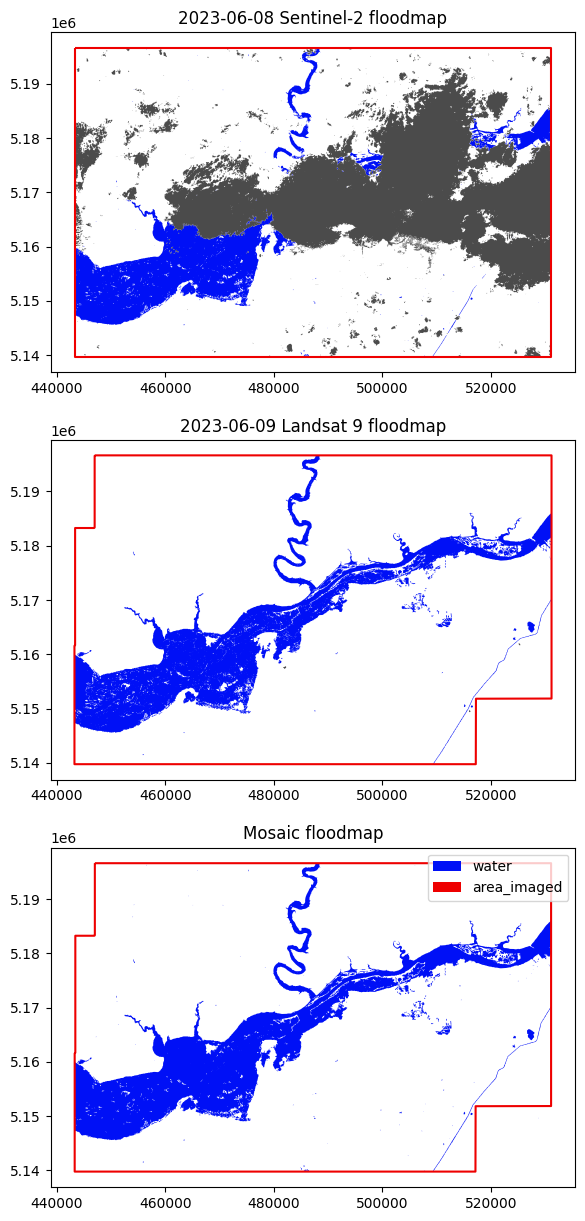

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
plot_utils.plot_floodmap(post_flood_shape, ax=ax[0], legend = False)
ax[0].set_title(f"{date_post} Sentinel-2 floodmap")
plot_utils.plot_floodmap(post_flood_shape_l9, ax=ax[1], legend = False)
ax[1].set_title(f"2023-06-09 Landsat 9 floodmap")
plot_utils.plot_floodmap(postflood_mosaic,ax = ax[2], legend = True)
ax[2].set_title(f"Mosaic floodmap")

<Axes: >

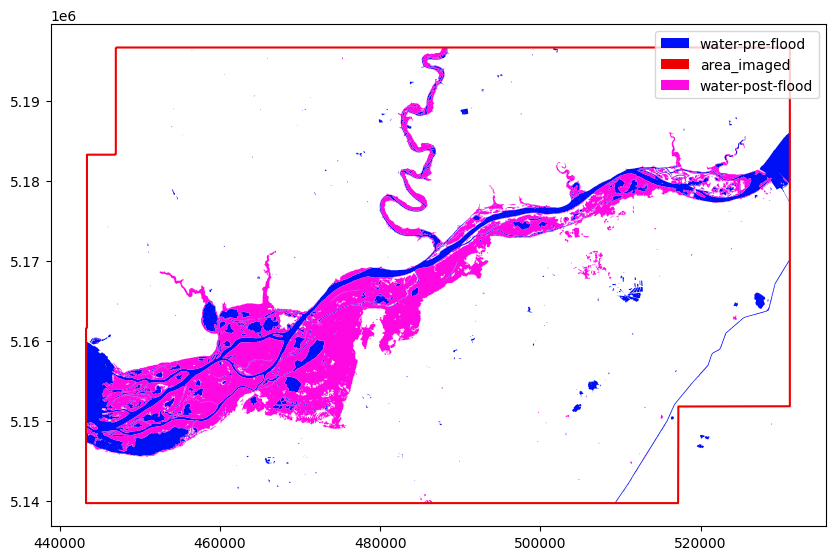

In [24]:
prepost_shape_final = postprocess.compute_pre_post_flood_water(postflood_mosaic, preflood_shape)
prepost_shape_final = prepost_shape_final.loc[prepost_shape_final['class'].isin(['water-pre-flood','water-post-flood','area_imaged'])]
plot_utils.plot_floodmap(prepost_shape_final)

## Licence
The ML4Floods package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *WorldFloods* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

 If you find this work useful please cite:
```
@article{portales-julia_global_2023,
	title = {Global flood extent segmentation in optical satellite images},
	volume = {13},
	issn = {2045-2322},
	doi = {10.1038/s41598-023-47595-7},
	number = {1},
	urldate = {2023-11-30},
	journal = {Scientific Reports},
	author = {Portalés-Julià, Enrique and Mateo-García, Gonzalo and Purcell, Cormac and Gómez-Chova, Luis},
	month = nov,
	year = {2023},
	pages = {20316},
}
```